In [1]:
import torch
import numpy as np
import torch.nn as nn
from torch.nn.modules.linear import Identity
from mae import MAE
from vit import *

from PIL import Image
import os

import matplotlib.pyplot as plt
import cv2
from torchvision.transforms import ToTensor, ToPILImage

from IPython.display import clear_output as clear

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
img_raw = Image.open(os.path.join("/home/purewhite/workspace/cg-proj/NUG-DLSS/imgs/img_origin.jpeg"))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

h, w = img_raw.height, img_raw.width
ratio = h / w
print(f"image hxw: {h} x {w} mode: {img_raw.mode}")

img_size, patch_size = (224, 224), (16, 16)
img = img_raw.resize(img_size)
rh, rw = img.height, img.width
print(f'resized image hxw: {rh} x {rw} mode: {img.mode}')


image hxw: 1080 x 1920 mode: RGB
resized image hxw: 224 x 224 mode: RGB


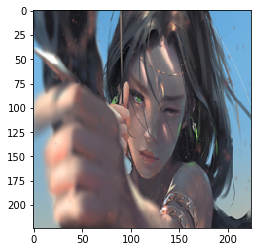

In [3]:
plt.figure(1)
plt.imshow(img)

In [4]:
img_ts = ToTensor()(img).unsqueeze(0).to(device)
print(f"input tensor shape: {img_ts.shape} dtype: {img_ts.dtype} device: {img_ts.device}")

encoder = ViT(img_size, patch_size, dim=512, mlp_dim=1024, dim_per_head=64)
decoder_dim = 512
mae = MAE(encoder, decoder_dim, decoder_depth=6)
mae.to(device)

input tensor shape: torch.Size([1, 3, 224, 224]) dtype: torch.float32 device: cpu


MAE(
  (encoder): ViT(
    (patch_embed): Linear(in_features=768, out_features=512, bias=True)
    (drouout): Dropout(p=0.0, inplace=False)
    (transformer): Transformer(
      (layers): ModuleList(
        (0): ModuleList(
          (0): PreNorm(
            (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
            (net): SelfAttention(
              (to_qkv): Linear(in_features=512, out_features=1536, bias=False)
              (attend): Softmax(dim=-1)
              (out): Sequential(
                (0): Linear(in_features=512, out_features=512, bias=True)
                (1): Dropout(p=0.0, inplace=False)
              )
            )
          )
          (1): PreNorm(
            (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
            (net): FFN(
              (net): Sequential(
                (0): Linear(in_features=512, out_features=1024, bias=True)
                (1): GELU()
                (2): Dropout(p=0.0, inplace=False)
               

In [5]:
import torch.optim as optim

optimizer = optim.Adam(mae.parameters(), lr=0.0001)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(224, 224, 3) (224, 224, 3)


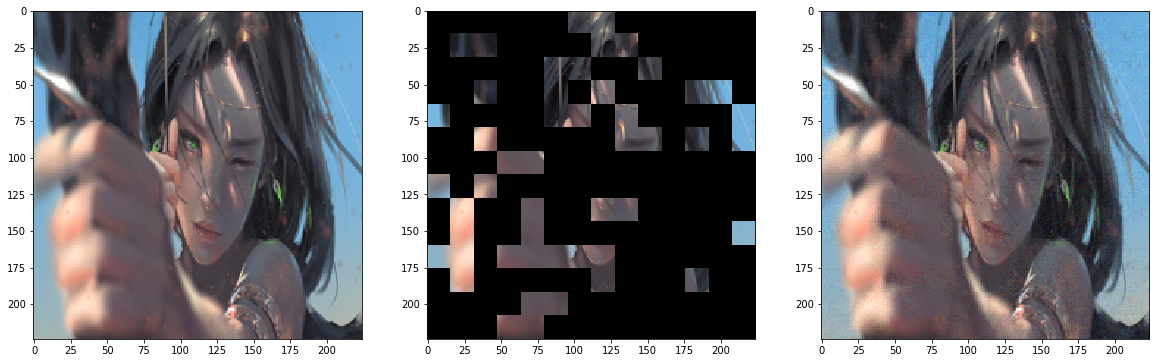

950 0.0007426253287121654


KeyboardInterrupt: 

In [6]:
def show_sample():
    clear()
    recons_img, patches_to_img = mae.predict(img_ts)

    recons_img = recons_img.squeeze(0).permute(1, 2, 0).numpy()
    patches_to_img = patches_to_img.squeeze(0).permute(1, 2, 0).numpy()
    print(recons_img.shape, patches_to_img.shape)

    plt.figure(1, (20, 20))
    plt.subplot(1, 3, 1)
    plt.imshow(img)

    plt.figure(1, (20, 20))
    plt.subplot(1, 3, 2)
    plt.imshow(patches_to_img)

    plt.figure(1, (20, 20))
    plt.subplot(1, 3, 3)
    plt.imshow(recons_img)
    
    plt.show()

for i in range(10000):
    optimizer.zero_grad()
    loss = mae(img_ts)
    if (i % 10 == 0):
        show_sample()
        print(i, loss.item())
    loss.backward()
    optimizer.step()